In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, sys

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras


Using TensorFlow backend.


# Segmentation: U-Net and rotationally invariant U-Net (GUNet)

In this notebook, we build two different models for binary segmentation of histological images. 

We use the [Warwick QU gland segmentation](https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/) (GlaS) data set consisting of H&E stained histological images from the GlaS@MICCAI 2015 competition. 

In [3]:
# URL of Warwick QU GlaS data set.
# will be downloaded and extracted to ~/.keras if not existent
URL = 'https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip'

# size of images for prediction
HEIGHT, WIDTH = 320, 448

# size of image patches for training 
PATCH_HEIGHT, PATCH_WIDTH = 64, 64


# Utility functions

In [4]:
def sort_human(strings):
    def atoi(text):
        return int(text) if text.isdigit() else text
    
    def human_keys(text):
        import re
        return [ atoi(c) for c in re.split('(\d+)', text) ]
    
    strings.sort(key=human_keys)
    return strings

def import_image(filename, scale=True, expand=None, verbose=True):
    """
    Read an image file.

    Args:
        filename (str): a file name (path)
        scale (bool): should the returned image be scaled to float32 [0,1]
        expand (int): expands the specified axis of the image (for keras with channels last this should be -1)
        verbose (bool): print information about the image

    Returns:
        (numpy.array) returns an numpy array containing the image
    """
    from skimage.io import imread, imsave

    if(filename.endswith('.tif')):
        image=imread(filename, plugin='tifffile')
    else:
        image=imread(filename, plugin='simpleitk')
    if scale:
        if image.dtype==np.bool:
            image=image.astype('float32')
        elif image.dtype==np.int8:
            image=(image.astype('float32')+(2**8/2))/(2**8-1)
        elif image.dtype==np.int16:
            image=(image.astype('float32')+(2**16/2))/(2**16-1)
        elif image.dtype==np.uint8:
            image=image.astype('float32')/(2**8-1)
        elif image.dtype==np.uint16:
            image=image.astype('float32')/(2**16-1)
        else:
            warnings.warn('Scaling for dtype {} is not yet implemented!'.format(image.dtype))
    if expand!=None:
        image=np.expand_dims(image,axis=expand)
    if verbose:
        image_info(image)
    return image

def draw_model(model):
    from IPython.display import display,SVG
    from keras.utils.vis_utils import model_to_dot
    return SVG(model_to_dot(model, show_shapes=False, show_layer_names=False, rankdir='LR').create(prog='dot', format='svg'))

# Get data

- Download data set

In [5]:
from pathlib import Path
home = str(Path.home())
data_folder = os.path.join(home, '.keras/datasets/Warwick QU Dataset (Released 2016_07_08)')

if not os.path.exists(data_folder):
    print('Downloading Warwick dataset')
    from keras.utils import get_file 
    dataset = get_file(
          fname=os.path.basename(URL),
          origin=url, 
          extract=True)
else:
    print('Warwick dataset found at {}'.format(data_folder) )
    print('Not downloading...')

Warwick dataset found at /home/debacwa/.keras/datasets/Warwick QU Dataset (Released 2016_07_08)
Not downloading...


- Read image files and masks

In [6]:
fns_images = sort_human(glob.glob(os.path.join(data_folder, 'train_*.bmp')))
fns_masks  = sort_human(glob.glob(os.path.join(data_folder, 'train_*_anno.bmp')))
# remove _anno.bmp from path_images
fns_images = sort_human(list(set(fns_images) - set(fns_masks)))

In [7]:
from skimage import transform

images=[]
for fn in fns_images:
    image = import_image(fn, scale=True, verbose=False)
    image = transform.resize(image, (HEIGHT, WIDTH), mode='constant')
    #print(fn, image.shape)
    images.append(image)
images = np.array(images)
print(images.shape, images.min(), images.max())

masks=[]
for fn in fns_masks:
    basename = os.path.splitext(os.path.basename(fn))[0].split('_anno')[0]
    image = import_image(fn, verbose=False)
    image = transform.resize(image, (HEIGHT, WIDTH), order=0, mode='constant')
    mask = np.array(image>0, np.uint8)[...,:1] 
    masks.append(mask)
    
masks = np.array(masks)

print(masks.shape)

print(len(np.unique(masks)))

(85, 320, 448, 3) 5.457298097727795e-08 1.0
(85, 320, 448, 1)
2


- data sample patches 

In [8]:
def sample_2Dtiles(image, annotation, tile_shape=(32,32), samples=10):
    sample_im=[]
    sample_mask=[]
    for i in range(samples):
        x = np.random.randint(0,image.shape[0]-tile_shape[0]-1)
        y = np.random.randint(0,image.shape[1]-tile_shape[1]-1)
        sample_im.append(   image[x:x+tile_shape[0],y:y+tile_shape[1]])
        sample_mask.append( annotation[x:x+tile_shape[0],y:y+tile_shape[1]])
    return np.array(sample_im), np.array(sample_mask)

In [9]:
X = []
Y = []
for im, mask in zip(images, masks):
    x,y = sample_2Dtiles(im, mask, tile_shape=(PATCH_HEIGHT, PATCH_WIDTH), samples=20)
    X.append(x)
    Y.append(y)
    #print(x.shape)
X = np.array(X)
X = X.reshape((X.shape[0]*X.shape[1], X.shape[2], X.shape[3], X.shape[4]))
Y = np.array(Y)
Y = Y.reshape((Y.shape[0]*Y.shape[1], Y.shape[2], Y.shape[3], Y.shape[4]))
print(X.shape, Y.shape)

(1700, 64, 64, 3) (1700, 64, 64, 1)


In [10]:
from sklearn.model_selection import train_test_split
x_validation, x_train, y_validation, y_train = train_test_split(X, Y, test_size=.8)
print('X training: {}'.format(x_train.shape))
print('X validation: {}'.format(x_validation.shape))
print('Y training: {}'.format(y_train.shape))
print('Y validation: {}'.format(y_validation.shape))

X training: (1360, 64, 64, 3)
X validation: (340, 64, 64, 3)
Y training: (1360, 64, 64, 1)
Y validation: (340, 64, 64, 1)


# Models

- create a plain UNet model
- create a rotationally invariant UNet model (GUNet) based on group convolutions

In [13]:
%load_ext autoreload
%autoreload 2

src_folder = '../src'
if src_folder not in sys.path:
    sys.path.append(src_folder)
from networks import UNet2, GUNet2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#unet = UNet(n_input_channels=3, n_output_channels=1, depth=4, max_filters=512, batchnorm=True, dropout=0.25)
unet = UNet2(n_input_channels=3, n_output_channels=1)

In [15]:
unet.count_params()

31056397

In [14]:
#n=123
#pred = unet.predict(x_train[n:n+1])
#plt.matshow(np.squeeze(pred))

In [15]:
#unet.summary()

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(unet).create(prog='dot', format='svg'))

In [16]:
#unet = UNet(n_input_channels=3, n_output_channels=1)

In [16]:
#gunet = GUNet(n_input_channels=3, n_output_channels=1, h='C4', depth=4, max_filters=512, batchnorm=True, dropout=0.25)
gunet = GUNet2(n_input_channels=3, n_output_channels=1, h='C4')

In [17]:
gunet.count_params()

124122321

In [18]:
np.round(gunet.count_params() / unet.count_params(), 1)

4.0

In [ ]:
gunet.predict(x_train[:1]).shape

# Loss function

We use the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) as a measure of similarity between the predicted binary mask and the ground truth mask. This is equivalent t the F1 The loss is simply the negative of the dice coefficient.

In [28]:
import keras.backend as K
smooth=1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)


# Train models

- define callback to plot progress

In [29]:
from IPython.display import clear_output
from keras.callbacks import Callback
class PlotLearning(Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('dice_coef'))
        
        self.val_loss.append(logs.get('val_loss'))        
        self.val_acc.append(logs.get('val_dice_coef'))
        
        self.i += 1
        f, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)
        ax = ax.flatten()
        clear_output(wait=True)
        
        ax[0].plot(self.x, self.loss, label="loss", lw=2)
        ax[0].plot(self.x, self.val_loss, label="val_loss")
        #ax[0].set_ylim(bottom=0.)
        ax[0].legend()
        ax[0].grid(True)
        
        ax[1].plot(self.x, self.acc, label="dice_coef", lw=2)
        ax[1].plot(self.x, self.val_acc, label="val_dice_coef")
        #ax[1].set_ylim(bottom=0.)
        ax[1].legend()
        ax[1].grid(True)
        
        plt.show();
        
plotLoss = PlotLearning()

In [33]:
batchsize = 8
epochs = 100
reload = False

- Train UNet

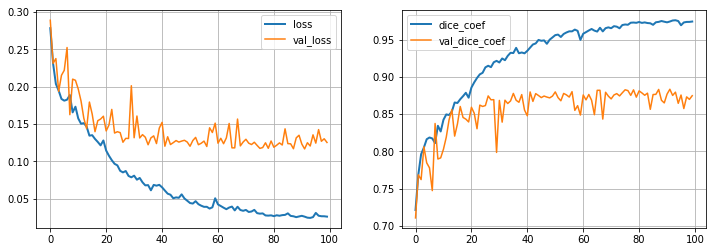

In [31]:
unet.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])

history_unet = unet.fit(x_train, y_train, batch_size=batchsize, epochs=epochs, 
                    verbose=1, shuffle=True, 
                    validation_data=(x_validation, y_validation),
                    callbacks=[plotLoss])



- Train GUNet

In [34]:
gunet.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])

history_gunet = gunet.fit(x_train, y_train, batch_size=batchsize, epochs=epochs, 
                    verbose=1, shuffle=True, 
                    validation_data=(x_validation, y_validation),
                    callbacks=[plotLoss])



Train on 1360 samples, validate on 340 samples
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[3,3,3072,1,512,4] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node up_0_2/transpose}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _class=["loc:@training_2/Adam/gradients/up_0_2/transpose_grad/transpose"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](up_0_2/GatherV2, g_conv2d_2/transpose/perm)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_2/mul/_1285}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4582_loss_2/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


<Figure size 432x288 with 0 Axes>

In [ ]:
# Predict rotated images

In [ ]:
def plot_predictions(n):
    pred_u = unet.predict(x_validation[n:n+1])
    pred_g =gunet.predict(x_validation[n:n+1])
    
    fig, ax = plt.subplots(1,3,figsize=(18,6))
    
    ax[0].imshow(np.squeeze(x_validation[n:n+1]))
    ax[1].imshow(np.squeeze(pred_u))
    ax[2].imshow(np.squeeze(pred_g))
    
    for a in ax: a.axis('off')
    
    plt.show()
    plt.close()

In [ ]:
plot_predictions(8)

# Predict

- some utility function to predict sample and plot predictions as overlays

In [ ]:
def sector_mask(shape,centre,radius,angle_range=None):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    # source: https://stackoverflow.com/a/18354475
    """

    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 <= radius*radius

    # angular mask
    if angle_range is None:
        anglemask = 1
    else:
        anglemask = theta <= (tmax-tmin)

    return circmask*anglemask

In [ ]:
def predict(model, num_samples=10, samples_ind=None, rotation=0):
    import time
    tic = time.time()
    if samples_ind is None:
        samples_ind = np.random.randint(0, len(images), num_samples)
    sample_images = images[samples_ind]
    sample_masks = masks[samples_ind]
    
    if rotation != 0:
        from skimage.transform import rotate
        sample_images = np.array([rotate(im, rotation) for im in sample_images])
        sample_masks  = np.array([rotate(im, rotation) for im in sample_masks])

        # mask circle
        center = (im.shape[0]//2, im.shape[1]//2)
        radius = min(im.shape[0]//2, im.shape[1]//2)
        circ_mask = sector_mask(im.shape, centre=center, radius=radius, angle_range=(0,360))
        def set_mask(im, mask):
            im[~mask] = 0
            return im
        sample_images = np.array([set_mask(im, circ_mask) for im in sample_images])
        sample_masks  = np.array([set_mask(im, circ_mask) for im in sample_masks])
        
    
    predictions = model.predict(sample_images, batch_size=4)
    toc = time.time()
    print('Time per image = {:.4f} sec'.format((toc-tic) / num_samples))
    return sample_images, sample_masks, predictions, samples_ind

def images_overlay(im1, im2, threshold=1e-2, title=None, alpha=0.25, cmap='Reds_r', ax=None, figsize=(5,5)):
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        
    im1 = np.squeeze(im1)
    im2 = np.squeeze(im2)
    
    ax.imshow(im1)

    mask = np.ma.masked_less(im2, threshold)
    ax.contourf(mask >  threshold, alpha=alpha, cmap=cmap)
    ax.contour(im2, levels=[threshold], alpha=1.0, cmap=cmap)
    
    ax.axis('off')
    
    if title is not None:
        ax.set_title(title, fontsize=14)
        
def plot_prediction(x, y, y_pred, sample):
    
    if sample >= len(y_pred):
        raise ValueError('sample {} does not exist, max = {}'.format(sample, len(y_pred)-1))
    
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    images_overlay(x[sample], y_pred[sample], ax=ax[0], title='prediction')
    images_overlay(x[sample], y[sample], ax=ax[1], title='annotation')
    

In [ ]:
# predict UNET
x_u, y_u, y_pred_u, samples_ind = predict(unet, num_samples=3, rotation=12)
# predict GUNET
x_m, y_m, y_pred_m, _ = predict(gunet, samples_ind=samples_ind, rotation=12)

## UNet

In [ ]:
sample = 2
plot_prediction(x_u, y_u, y_pred_u, sample=sample)

## GUNet

In [ ]:
plot_prediction(x_m, y_m, y_pred_m, sample=sample)